In [1]:
import rebound
import matplotlib.pyplot as plt
import numpy as np
import time
import math
from scipy import optimize

%matplotlib inline

# start with 2 bodies vanilla WH
# add Inertial -> Cartesian transform (June 9)

# setup
# start with positions and velocities of 2 bodies
# r0 = (0, 0), v1 = (1, 0)
# r1 = (0, 1), v2 = (-1, 0)

# alg
# 0. Transform to Jacobian coordinates
# 1. Drift: advance system by half timestep h/2 by Keplerian part K
# 2. Kick: advance system by timestep h using R as Hamiltonian
# 3. Drift: repeat 1.
# 4. Repeat 1. to 3.

# G-functions (take in beta, X,...)

# f-g formulation of Keplerian motion (2-body motion)
# 1. calculate beta, eta_0, zeta_0
# 2. solve X from t(X) = h
# 3. solve f and g
# 4. solve new position and velocity from previous timestep using f and g

In [9]:
def drift(simj, object_num, h):
    """
    Advance (Keplerian part) system by timestep h
    
    Args:
        r::1D array
            Position (x, y)
        v::1D array
            Velocity (vx, vy)
        M::float
            Central mass
        h::float
            timestep

    Returns:
        r::float
            New position
        v::float
            New velocity
    """
    
    r = simj[object_num, :2]
    v = simj[object_num, 2:4]
    M = simj[object_num-1, 4]
    
    r0 = np.sqrt(r[0]**2 + r[1]**2)
    r0i = 1./r0  #r0 inverse
    v2 = v[0]**2 + v[1]**2
    beta = 2*M*r0i - v2
    eta0 = r[0]*v[0] + r[1]*v[1]
    zeta0 = M - beta*r0

    # Solve Kepler's equation for X
    dtr0i = h * r0i # first order guess
    X_guess = dtr0i * (1 - dtr0i*eta0*0.5*r0i) # second order guess (according to Rebound)
    
    X = optimize.newton(func=Keplers_eqn, x0=X_guess, args=(r0, beta, eta0, zeta0, h))
    
    G1 = calculate_G(1, beta, X) 
    G2 = calculate_G(2, beta, X)
    G3 = calculate_G(3, beta, X)
    
    ri = 1./(r0 + eta0*G1 + zeta0*G2)
    f = 1 - M*G2*r0i
    g = h - M*G3
    fd = -M*G1*r0i*ri   # time derivative of f
    gd = 1 - M*G2*ri    # time derivative of g
    
    # solve for new position and velocity using the f and g functions
    rx = f*r[0] + g*v[0]
    ry = f*r[1] + g*v[1]
    vx = fd*r[0] + gd*v[0]
    vy = fd*r[1] + gd*v[1]

    simj[1, 0] = rx
    simj[1, 1] = ry
    simj[1, 2] = vx
    simj[1, 3] = vy

    return simj

def Keplers_eqn(X, r0, beta, eta0, zeta0, h):
    """
    Kepler's equation as described in eqn. (11) of Mikkola & Innanen 1999
    """
    term1 = r0 * X
    term2 = eta0 * calculate_G(2, beta, X)
    term3 = zeta0 * calculate_G(3, beta, X)
    return term1 + term2 + term3 - h

def calculate_G(n, beta, X):
    """
    G-functions as described in eqn. (9) of Mikkola & Innanen 1999
    """
    return X**n * calculate_c(n, beta*X**2)

def c(n, z, j):
    """
    Helper function to calculate_c
    """
    return (-z)**j / (math.factorial(n + 2*j))
    
def calculate_c(n, z):
    """
    c-functions as described in eqn. (7) of Mikkola & Innanen 1999
    """
    
    tolerance = 0.001 # stop expansion when adding the jth term changes c by less than tolerance
    j = 2 # number of terms in series expansion, after 0 and 1
    
    current_c = c(n, z, 0)
    next_c = current_c + c(n, z, 1)
    
    while (abs(current_c-next_c) > tolerance):
        current_c = next_c
        next_c += c(n, z, j)
        j += 1
        
    return next_c

def move_to_com(sim):
    """
    Convert from heliocentric to inertial centre-of-mass frame
    """
    
    r0 = sim[0, :2]
    m0 = sim[0, 4]
    r1 = sim[1, :2]
    m1 = sim[1, 4]
    
    COM_x = (m0*r0[0] + m1*r1[0]) / (m0 + m1)
    COM_y = (m0*r0[1] + m1*r1[1]) / (m0 + m1)
    
    r0[0] -= COM_x
    r0[1] -= COM_y
    r1[0] -= COM_x
    r1[1] -= COM_y

    sim[0, 0] = r0[0]
    sim[0, 1] = r0[1]
    sim[1, 0] = r1[0]
    sim[1, 1] = r1[1]
    
    return sim
    
def inertial_to_jacobi(sim):
    """
    Jacobi Coordinates: coordinates are measured relative to the COM of all inner bodies
    
    This follows transformations.c from Rebound, WHFast paper, and Mikkola & Innanen 1999
    """
    
    r0 = sim[0, :2]
    v0 = sim[0, 2:4]
    m0 = sim[0, 4]
    r1 = sim[1, :2]
    v1 = sim[1, 2:4]
    m1 = sim[1, 4]
    
    COM_x = m0 * r0[0]
    COM_y = m0 * r0[1]
    COM_vx = m0 * v0[0]
    COM_vy = m0 * v0[1]
    
    # Iterate over objects from inner planet to outer planet with a for loop
    r1j_x = r1[0] - COM_x/m0
    r1j_y = r1[1] - COM_y/m0
    v1j_x = v1[0] - COM_vx/m0
    v1j_y = v1[1] - COM_vy/m0
    
    COM_x = COM_x * (1+m1/m0) + m1*r1j_x
    COM_y = COM_y * (1+m1/m0) + m1*r1j_y
    COM_vx = COM_vx * (1+m1/m0) + m1*v1j_x
    COM_vy = COM_vy * (1+m1/m0) + m1*v1j_y
    
    # Set the Jacobi coordinate for the central object
    r0j_x = COM_x/(m0+m1)
    r0j_y = COM_y/(m0+m1)
    v0j_x = COM_vx/(m0+m1)
    v0j_y = COM_vy/(m0+m1)
    
    # Calculate Jacobi mass
    m0j = m0 + m1
    m1j = m0*m1 / (m0 + m1)
    
    p0j = np.array([r0j_x, r0j_y, v0j_x, v0j_y, m0j])
    p1j = np.array([r1j_x, r1j_y, v1j_x, v1j_y, m1j])
    
    simj = np.stack([p0j, p1j])
    
    return simj

def jacobi_to_inertial(simj, sim):
    """
    reverse of inertial_to_jacobi
    """

    #print(type(simj))
    r0j = simj[0, :2]
    v0j = simj[0, 2:4]
    m0 = sim[0, 4]
    r1j = simj[1, :2]
    v1j = simj[1, 2:4]
    m1 = sim[1, 4]
    
    COM_x = m0 * r0j[0]
    COM_y = m0 * r0j[1]
    COM_vx = m0 * v0j[0]
    COM_vy = m0 * v0j[1]
    
    # Iterate over objects from outer planet to inner planet with a for loop
    COM_x = (COM_x - m1*r1j[0]) / (m0 + m1)
    COM_y = (COM_y - m1*r1j[1]) / (m0 + m1)
    COM_vx = (COM_vx - m1*v1j[0]) / (m0 + m1)
    COM_vy = (COM_vy - m1*v1j[1]) / (m0 + m1)
    
    r1_x = r1j[0] + COM_x
    r1_y = r1j[1] + COM_y
    v1_x = v1j[0] + COM_vx
    v1_y = v1j[1] + COM_vy
    
    COM_x *= m0
    COM_y *= m0 
    COM_vx *= m0
    COM_vy *= m0 
    
    # Set the inertial coordinate for the central object
    r0_x = COM_x/m0
    r0_y = COM_y/m0
    v0_x = COM_vx/m0
    v0_y = COM_vy/m0
    
    p0 = np.array([r0_x, r0_y, v0_x, v0_y, m0])
    p1 = np.array([r1_x, r1_y, v1_x, v1_y, m1])
    
    sim = np.stack([p0, p1])
    
    return sim

In [20]:
# initial conditions

# particle array as [rx, ry, vx, vy, m]
p0 = np.array([0., 0., 0., 0., 2.])
p1 = np.array([1., 0., 0., 1., 1e-3])
sim = np.stack([p0, p1])

sim = move_to_com(sim)

timestep = 0.01
N_steps = 1000
rx, ry = np.zeros(N_steps), np.zeros(N_steps)
vx, vy = np.zeros(N_steps), np.zeros(N_steps)

start = time.time()

for i in range(N_steps):

    simj = inertial_to_jacobi(sim)
    simj = drift(simj, object_num = 1, h=timestep)
    sim = jacobi_to_inertial(simj, sim)
    
    #sim = drift(sim, h=timestep)
    
    rx[i], ry[i] = sim[1,0], sim[1,1]
    vx[i], vy[i] = sim[1,2], sim[1,3]
    
end = time.time()

print('time to integrate =', np.round(end - start, 1), 's')

time to integrate = 0.2 s


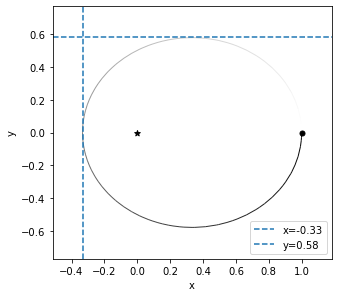

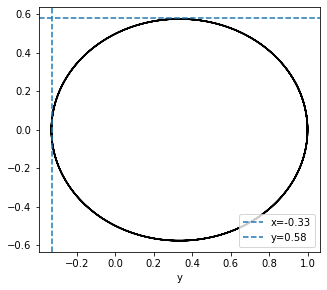

In [23]:
#M = 10

fig, ax = rebound.OrbitPlot(sim)
ax.axvline(-0.33, ls='--', label='x=-0.33')
ax.axhline(0.58, ls='--', label='y=0.58')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(10,4.5))
plt.plot(rx, ry, c='black')
plt.axvline(-0.33, ls='--', label='x=-0.33')
plt.axhline(0.58, ls='--', label='y=0.58')
plt.axis('scaled')
plt.xlabel('x')
plt.xlabel('y')
plt.legend(loc='lower right')
plt.show()

In [ ]:
sim = rebound.Simulation()

sim.add(m=1, x=1.1, y=2.2, vx=0., vy=0.)
sim.add(m=1, x=3.3, y=4.4, vx=0., vy=1.)

sim.move_to_com()

print(sim.particles[0].x,sim.particles[0].y,sim.particles[1].x,sim.particles[1].y)

sim.particles[0].jacobi_com.x, sim.particles[0].jacobi_com.y, sim.particles[1].jacobi_com.x, sim.particles[1].jacobi_com.y
# sim.

In [22]:
sim = rebound.Simulation()
sim.add(m=2.)
sim.add(x=1., y=0., vx=0., vy=1.)
#sim.integrate(1) 
